In [1]:
import gzip
from collections import defaultdict
import math
import operator
import scipy.optimize
from sklearn import svm
import numpy as np
import string
import random
import string
from sklearn import linear_model
import warnings
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import scipy
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split, cross_validate

from nltk import word_tokenize
class Utilites:
    def readGz(path):
        for l in gzip.open(path, 'rt'):
            yield eval(l)


    def readCSV(path):
        f = gzip.open(path, 'rt')
        f.readline()
        for l in f:
            u, b, r = l.strip().split(',')
            r = int(r)
            yield u, b, r

    def Cosine(x1, x2):
        numer = 0
        norm1 = 0
        norm2 = 0
        for a1, a2 in zip(x1, x2):
            numer += a1*a2
            norm1 += a1**2
            norm2 += a2**2
        if norm1*norm2:
            return numer / math.sqrt(norm1*norm2)
        return 0

    def printResult(scores, scoring = ['accuracy', 'f1', 'roc_auc']):
        for s in scoring:
            key = "test_%s" % (s)
            metric = scores[key]
            print("%0.4f validation %s with a standard deviation of %0.4f" % (metric.mean(), s, metric.std()))

    def printTestResult(actual, pred):
        print("Test Accuracy: %0.4f" % accuracy_score(actual, pred))
        print("Test F1 score: %0.4f" % f1_score(actual, pred))
        print("Test roc_auc: %0.4f" % roc_auc_score(actual, pred))
        print(confusion_matrix(actual, pred))


### Prepare Dataset

In [2]:
users_review_data = []
for d in Utilites.readGz("/work/user_reviews.json.gz"):
    users_review_data.append(d)

In [3]:
reviews = []
item_reviews = defaultdict(list)
user_reviews = defaultdict(list)
rec = []
text = []

for user in users_review_data:
    reviews.extend(user['reviews'])
    user_reviews[user['user_id']] = [r['review'] for r in user['reviews']]
    rec.extend([int(r['recommend']) for r in user['reviews']])
    text.extend( [r['review'] for r in user['reviews']] )

for r in reviews:
    item_reviews[r['item_id']].append(r['review'])

In [4]:
# Build balanced test set, 80-20 split
split = int(len(rec) * 0.8)
text_train = text[:split]
text_test = text[split:]
rec_train = rec[:split]
rec_test = rec[split:]


sort_index = np.argsort(rec_test)

sorted_rec = np.array(rec_test)[sort_index]
non_rec_len = len(sorted_rec) - np.count_nonzero(sorted_rec)

non_rec = list(sorted_rec[:non_rec_len])
rec_1 = list(sorted_rec[non_rec_len: 2 * non_rec_len])
rec_myTest = non_rec + rec_1

sorted_text = np.array(text_test)[sort_index]
non_rec_text = list(sorted_text[:non_rec_len])
rec_text = list(sorted_text[non_rec_len: 2 * non_rec_len])
text_myTest = non_rec_text + rec_text

### Trivial Approach 1:  Recommend Every Game

In [ ]:
trivial_pred = np.ones(len(rec_myTest))

print(confusion_matrix(rec_myTest, trivial_pred))
accuracy_score(rec_myTest, trivial_pred), f1_score(rec_myTest, trivial_pred)


[[   0 1037]
 [   0 1037]]


(0.5, 0.6666666666666666)

### Trivial Approach 2: Text Length & Exclamation Mark

In [ ]:
def feature(review_text):
    return [1, len(review_text), review_text.count('!')]

In [ ]:
X_train = [feature(re) for re in text_train]
X_test = [feature(re) for re in text_myTest]

model = linear_model.LogisticRegression(C = 1)
model.fit(X_train, rec_train)
pred = model.predict(X_test)

print(confusion_matrix(rec_myTest, pred))
accuracy_score(rec_myTest, pred), f1_score(rec_myTest, pred)

[[   1 1036]
 [   0 1037]]


(0.5004821600771456, 0.6668810289389067)

### TF-IDF

#### Logistic w/o balanced weight

Confusion Matrix: [0,0] = TN, [0, 1] == FP, [1,0] = FN, [1, 1] == TP

In [28]:
tdidf_vec = TfidfVectorizer(stop_words = "english", analyzer='word', sublinear_tf=True,
                            strip_accents='unicode', token_pattern=r'\w{2,}', ngram_range=(1, 1), 
                            max_df=1.0, min_df=1,
                            max_features=30000)

tdidf_vec.fit(text_train)
X_train = tdidf_vec.transform(text_train)
X_test = tdidf_vec.transform(text_myTest)

In [ ]:
logit = linear_model.LogisticRegression(C = 2.0, solver='sag')
logit.fit(X_train, rec_train)

# 10 Folds Validation
scoring = ['accuracy', 'f1', 'roc_auc']
scores = cross_validate(logit, X_train, rec_train, scoring=scoring,
                        cv=10, return_train_score=True)

In [ ]:
Utilites.printResult(scores, scoring)
pred = logit.predict(X_test)
Utilites.printTestResult(rec_myTest, pred)

0.9058 validation accuracy with a standard deviation of 0.0032
0.9483 validation f1 with a standard deviation of 0.0017
0.8912 validation roc_auc with a standard deviation of 0.0097
Test Accuracy: 0.6692
Test F1 score: 0.7483
Test roc_auc: 0.6692
[[ 368  669]
 [  17 1020]]


##### Logistic w/ balanced weight

In [ ]:
logit_balanced = linear_model.LogisticRegression(C = 2.0, solver='sag', class_weight='balanced') 
logit_balanced.fit(X_train, rec_train)

# 10 Folds Validation
scores_balanced = cross_validate(logit_balanced, X_train, rec_train, scoring=scoring,
                        cv=10, return_train_score=True)

In [ ]:
Utilites.printResult(scores_balanced)
pred_balanced = logit_balanced.predict(X_test)
Utilites.printTestResult(rec_myTest, pred_balanced)

0.8598 validation accuracy with a standard deviation of 0.0045
0.9168 validation f1 with a standard deviation of 0.0028
0.8879 validation roc_auc with a standard deviation of 0.0097
Test Accuracy: 0.8100
Test F1 score: 0.8285
Test roc_auc: 0.8100
[[728 309]
 [ 85 952]]


##### SVC w/o balanced weight

In [ ]:
svc = svm.LinearSVC(C = 0.35)
svc.fit(X_train, rec_train)

# 10 Folds Validation
scores_svc = cross_validate(svc, X_train, rec_train, scoring=scoring,
                        cv=10, return_train_score=True)

In [ ]:
Utilites.printResult(scores_svc)
pred_svc = svc.predict(X_test)
Utilites.printTestResult(rec_myTest, pred_svc)

0.9060 validation accuracy with a standard deviation of 0.0038
0.9484 validation f1 with a standard deviation of 0.0020
0.8863 validation roc_auc with a standard deviation of 0.0100
Test Accuracy: 0.6760
Test F1 score: 0.7522
Test roc_auc: 0.6760
[[ 382  655]
 [  17 1020]]


In [ ]:
svc_balanced = svm.LinearSVC(C = 0.35, class_weight='balanced')
svc_balanced.fit(X_train, rec_train)

# 10 Folds Validation
scores_svc_balanced = cross_validate(svc_balanced, X_train, rec_train, scoring=scoring,
                        cv=10, return_train_score=True)

In [ ]:
Utilites.printResult(scores_svc_balanced)
pred_svc_balanced = svc_balanced.predict(X_test)
Utilites.printTestResult(rec_myTest, pred_svc_balanced)

0.8602 validation accuracy with a standard deviation of 0.0046
0.9174 validation f1 with a standard deviation of 0.0030
0.8814 validation roc_auc with a standard deviation of 0.0103
Test Accuracy: 0.7994
Test F1 score: 0.8204
Test roc_auc: 0.7994
[[708 329]
 [ 87 950]]


## Preprocessing Methods

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lm = nltk.WordNetLemmatizer()
punctuation = set(string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
    
def tokenization(text):
    tokens = re.split('W+',text)
    return tokens


In [7]:
def feature2(d):
    r = d.lower()
    r = ''.join([c for c in r if not c in punctuation])
    r = remove_stopwords(r)
    r = lemmatizer_on_text(r)
    return r

In [23]:
import nltk
nltk.download('brown')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [13]:
from nltk.corpus import brown
words = set(w.lower() for w in brown.words())

## Testing

### Tester 1 - with all preprocessing methods

In [15]:
df = pd.DataFrame(list(zip(text, rec)), columns =['review', 'rec']) 

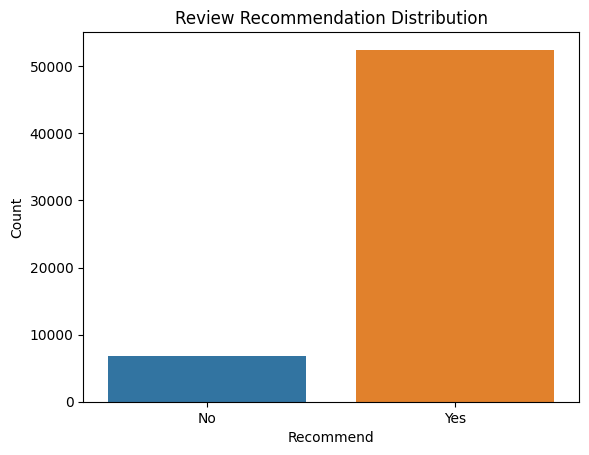

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = sns.countplot(x=df['rec'])
fig.set_xticklabels(['No', 'Yes'])
fig.set_xlabel('Recommend')
fig.set_ylabel('Count')
fig.set_title('Review Recommendation Distribution')
plt.savefig('rec_distribution.png')

In [18]:
df['rec'].value_counts(normalize = True)

1    0.884799
0    0.115201
Name: rec, dtype: float64

In [19]:
import random
rec = (df[df['rec'] == 1]).sample(n = 6832)
notRec = df[df['rec'] == 0]
total = pd.concat([rec, notRec])

text = list(total['review'])
y = list(total['rec'])

In [24]:
X = [feature2(d) for d in text]
x_train, x_val, ytrain, yval = train_test_split(X,
                                              y, test_size=0.2)

In [ ]:
wordLst = []
for s in X:
    for word in s.split():
        wordLst.append(word)

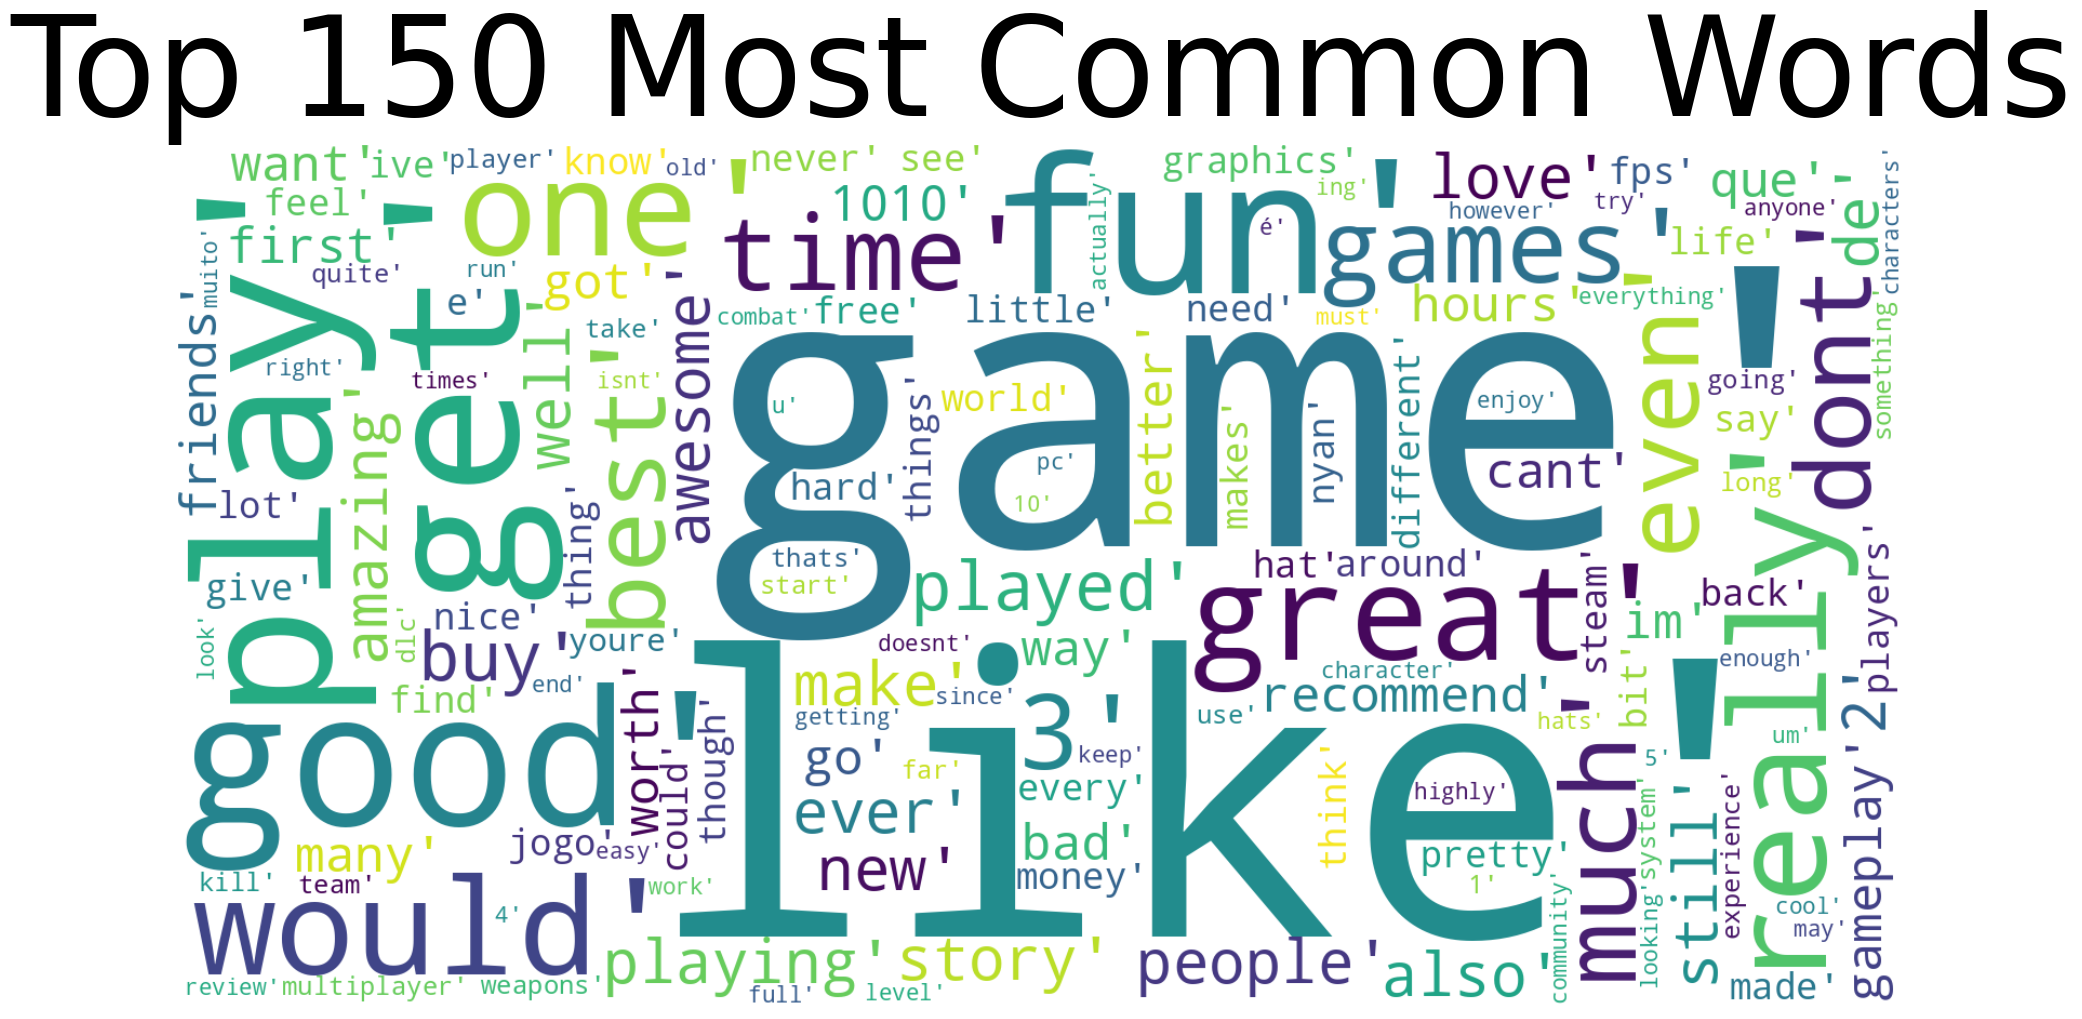

In [ ]:
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

mostcommon = FreqDist(wordLst).most_common(150)

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 150 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.savefig('150_most_common.png')
plt.show()

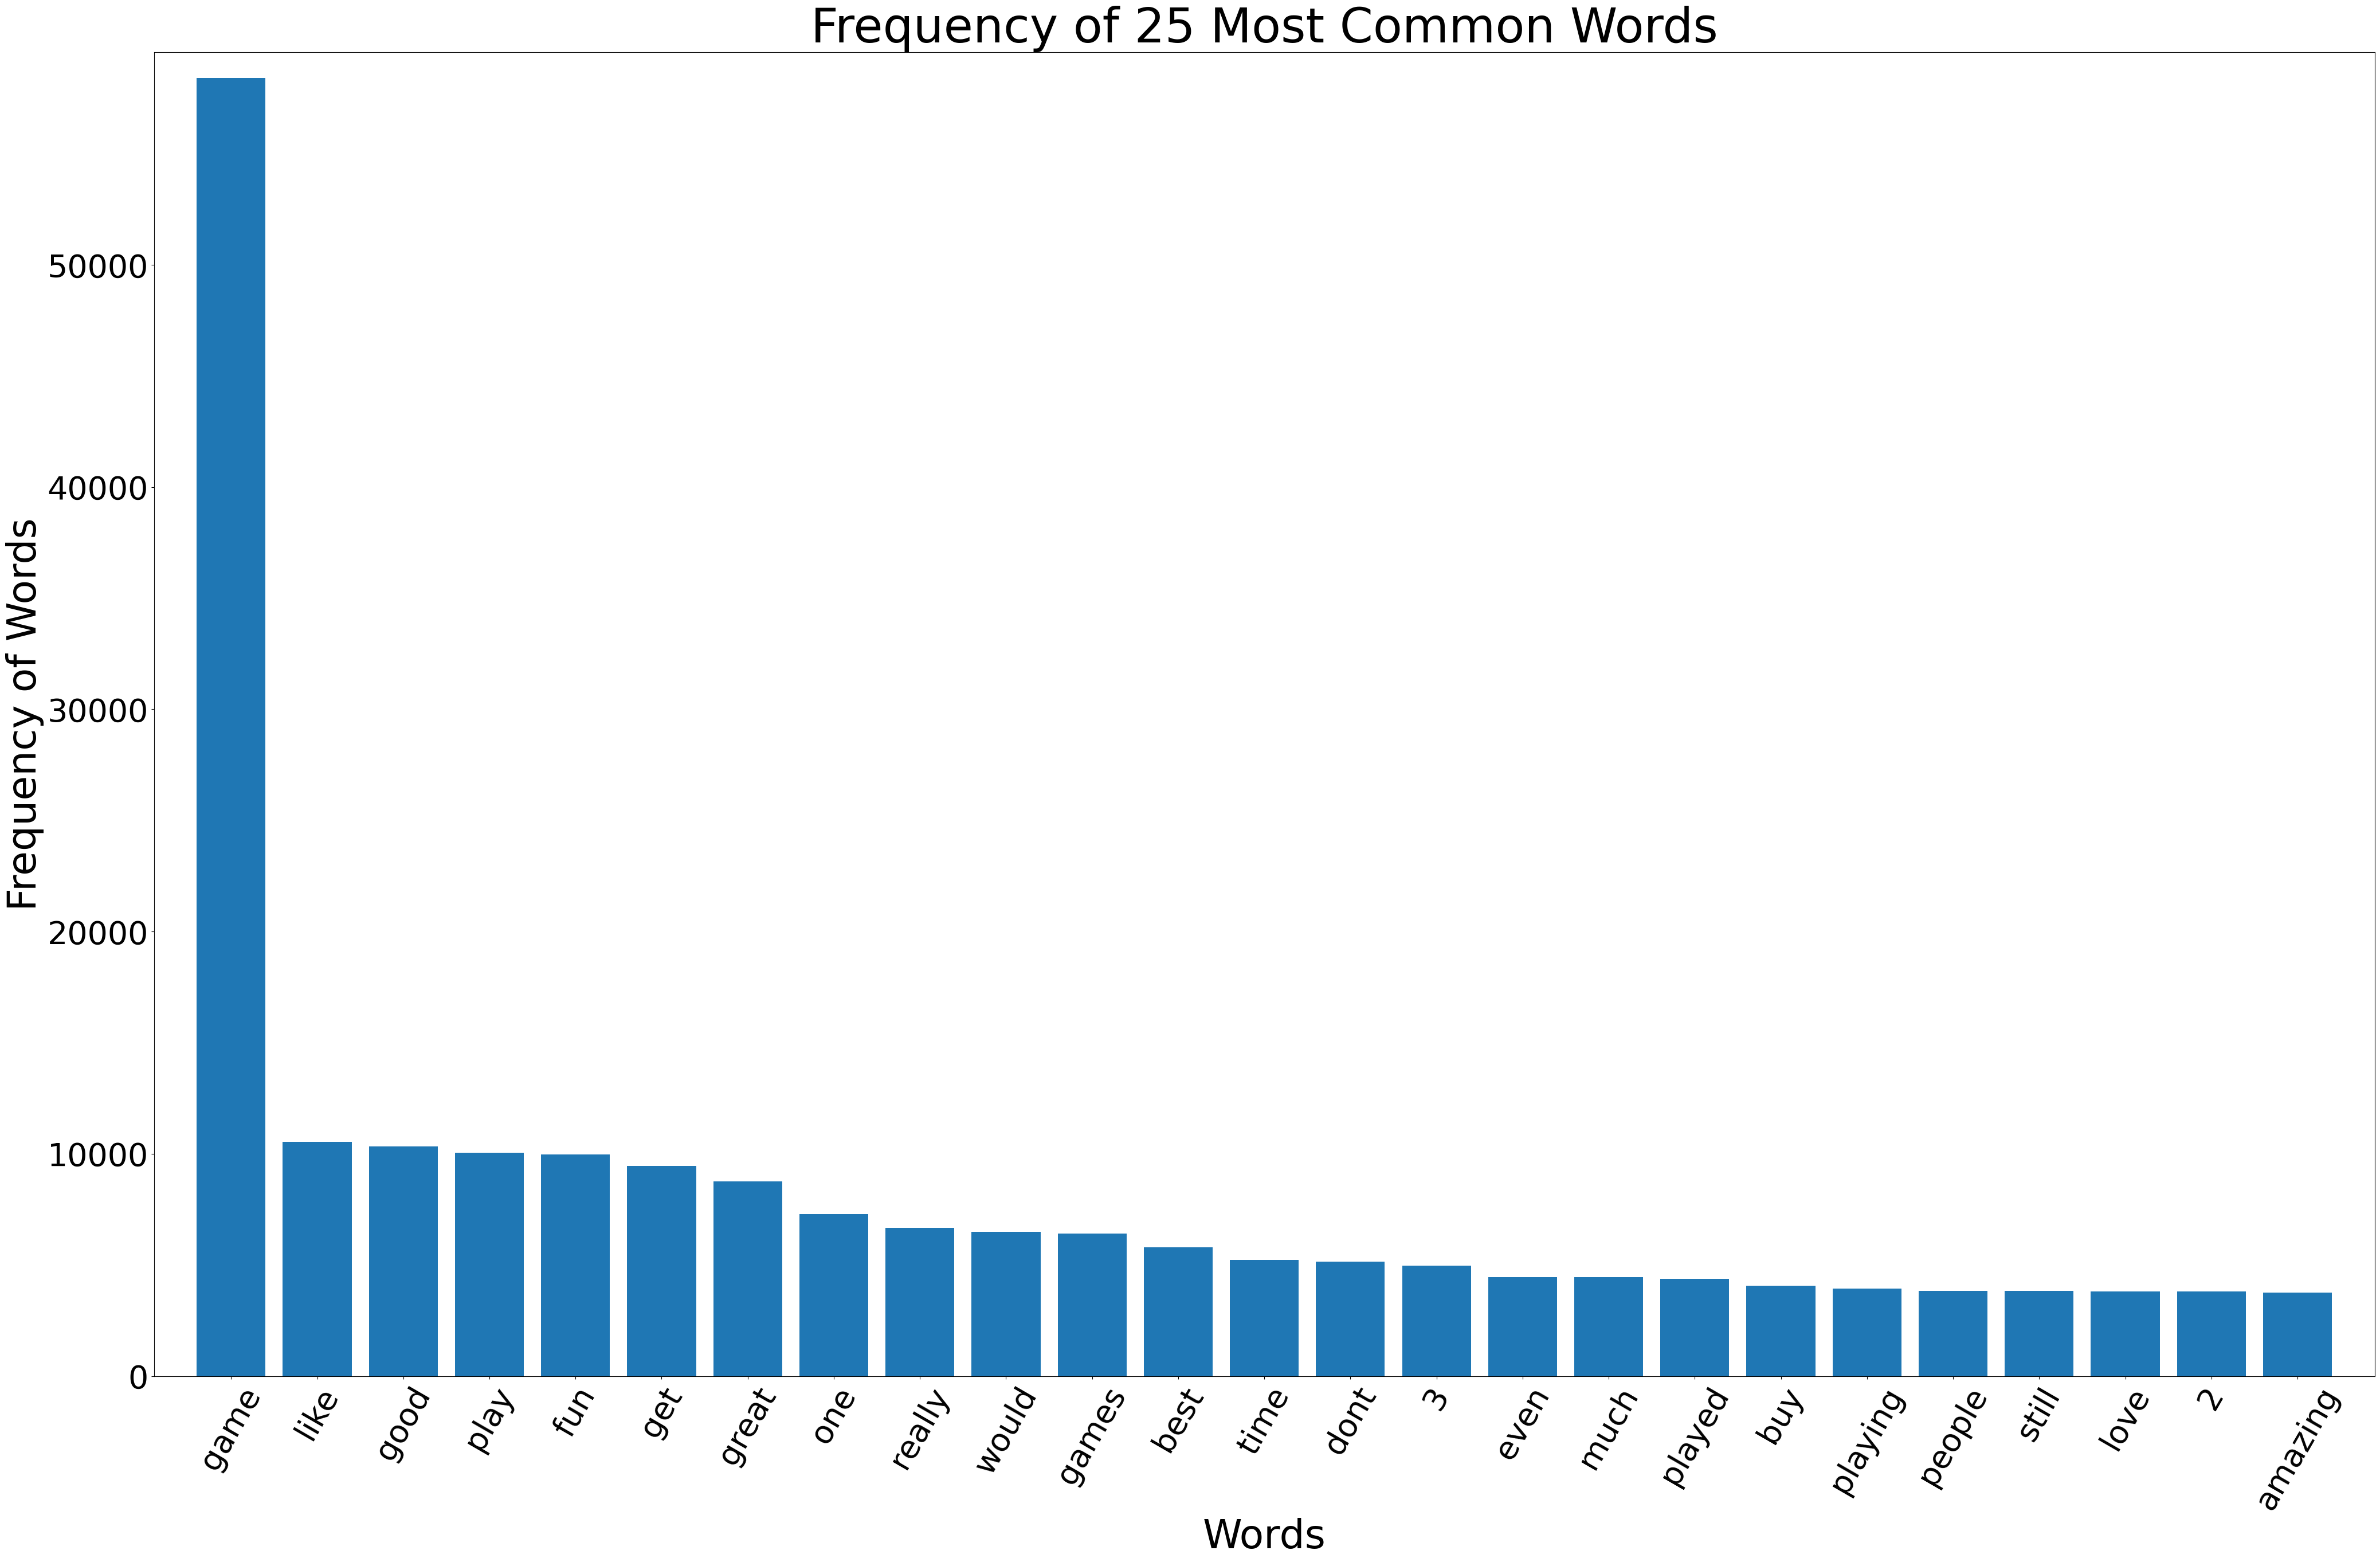

In [ ]:
mostcommon_small = FreqDist(wordLst).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.savefig('25_most_common.png')
plt.show()

In [31]:

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)
xtrain = tfidf_vectorizer.fit_transform(x_train)
xval = tfidf_vectorizer.transform(x_val)






# In[85]:


#logistic regression model
clf = LogisticRegression(random_state=0).fit(xtrain, ytrain)
print(clf.score(xval, yval))
clf_pred = clf.predict(xval)
Utilites.printTestResult(yval, clf_pred)

0.8005854372484449
Test Accuracy: 0.8006
Test F1 score: 0.8030
Test roc_auc: 0.8005
[[1077  278]
 [ 267 1111]]


In [ ]:
acclst = []
for i in [10**(-4), 10**(-3),10**(-2),10**(-1),10**(0), 10**(1), 10**(2), 10**(3), 10**(4)]:
    clf = LogisticRegression(random_state=0, C=i).fit(xtrain, ytrain)
    acclst.append(clf.score(xval, yval))

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

In [ ]:
acclst

[0.5653128430296378,
 0.7094767654592024,
 0.7383827296011709,
 0.7771679473106476,
 0.800951335528723,
 0.7958287596048299,
 0.7669227954628614,
 0.7336260519575558,
 0.721185510428101]

In [ ]:
from sklearn import svm
svc = svm.SVC(kernel = 'linear', C = 1.0)
svc.fit(xtrain, ytrain)
svc.score(xval, yval)

0.7976582510062202

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=42a14951-a6b0-41d0-afe4-98108502f667' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>